# Logistic Regression

I created a logistic regression model to try and predict whether or not the solver would correctly guess the wordle based on what the hidden word actually is. I used 2 different libraries for this: statsmodels and sklearn.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
from scipy.stats import chi2

In [2]:
# Import our data set
data = pd.read_csv('wordleData.csv')

One of the glaring issues with this data set was the much greater amount of wins compared to losses in our model.

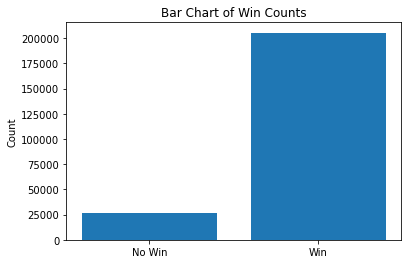

In [3]:
# Bar Chart
win_count = data['WinStatus'].value_counts()
plt.bar(win_count.index, win_count.values)
plt.ylabel('Count')
plt.xticks(win_count.index, ['Win', 'No Win'])
plt.title('Bar Chart of Win Counts')
plt.show()

To address this, I used SMOTE to artifically increase the size of the minority group when building the regression model.

In [4]:
smote = SMOTE(random_state=42)

There were three predictor variables that were recorded: the number of vowels, the number of duplicate set (e.g. two 2 a's and 2 e's would count as 2 sets), and the highest number of duplicates in the word (e.g. if a word were to have 2 a's and 3 e's, the "degree" would be 3). The latter 2 of these variables have some dependence on eachother, given that as the degree increases, the number of possible duplicate sets decreases. As a resulted, I included an interaction term.

Below is the full logistic regression model.

In [5]:
# Full Model

data['DuplicateSets*DuplicateDegree'] = data['DuplicateSets'] * data['DuplicateDegree']
XF = data[['Vowels', 'DuplicateSets', 'DuplicateDegree', 'DuplicateSets*DuplicateDegree']]
XF = sm.add_constant(XF)
Y = data['WinStatus']

XF_R, Y_R = smote.fit_resample(XF, Y)

fm = sm.Logit(Y_R, XF_R)
fm_result = fm.fit()
print(fm_result.summary())

Optimization terminated successfully.
         Current function value: 0.685181
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              WinStatus   No. Observations:               410780
Model:                          Logit   Df Residuals:                   410775
Method:                           MLE   Df Model:                            4
Date:                Mon, 17 Jul 2023   Pseudo R-squ.:                 0.01149
Time:                        18:26:22   Log-Likelihood:            -2.8146e+05
converged:                       True   LL-Null:                   -2.8473e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             1.0800      0.036     30.218      0.

And the reduced model.

In [6]:
# Reduced Model

XR = data[['Vowels']]
XR = sm.add_constant(XR)
Y = data['WinStatus']

XR_R, Y_R = smote.fit_resample(XR, Y)

rm = sm.Logit(Y_R, XR_R)
rm_result = rm.fit()
print(rm_result.summary())

Optimization terminated successfully.
         Current function value: 0.691521
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:              WinStatus   No. Observations:               410780
Model:                          Logit   Df Residuals:                   410778
Method:                           MLE   Df Model:                            1
Date:                Mon, 17 Jul 2023   Pseudo R-squ.:                0.002347
Time:                        18:26:25   Log-Likelihood:            -2.8406e+05
converged:                       True   LL-Null:                   -2.8473e+05
Covariance Type:            nonrobust   LLR p-value:                1.408e-292
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3252      0.009    -34.426      0.000      -0.344      -0.307
Vowels         0.1863      0.

I wanted to see the significance of the duplicate set count and duplicate degree as a predictor for our model and performed a likelihood ratio test (H_0: There is no statistical significance between the 2 models; H_A: There is a statistical signficance between the 2 models.

In [7]:
# Likelihood Ratio Test

llr = -2 * (rm_result.llf - fm_result.llf)
df = fm_result.df_model - rm_result.df_model
p_value = chi2.sf(llr, df)

print("Likelihood Ratio Test:\n-------------------------")
print("Test Statistic:", llr)
print("Degrees of Freedom:", df)
print("P-value:", p_value)

Likelihood Ratio Test:
-------------------------
Test Statistic: 5208.10260890855
Degrees of Freedom: 3.0
P-value: 0.0


The result was a very small p-value, practically 0. As a result, we reject the null; the full model would be more appropiate to use.

Now let's use the more machine-learning oriented sklearn library to continue our work on our regression model.

In [8]:
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

Sklearn can also be used to build logistic regression models with some differences, mainly by setting regularization on by default. 

In [9]:
X = data[['Vowels', 'DuplicateSets', 'DuplicateDegree', 'DuplicateSets*DuplicateDegree']]
y = data['WinStatus']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

model = LogisticRegression()
model.fit(X_train_resampled, y_train_resampled)

y_pred_probs = model.predict_proba(X_test)[:, 1]

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)
precision = (confusion_mat[1][1])/(confusion_mat[1][1]+confusion_mat[0][1])
recall = (confusion_mat[1][1])/(confusion_mat[1][1]+confusion_mat[1][0])
f1 = 2*(precision*recall)/(precision+recall)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Accuracy: 0.6625701943844492
Precision: 0.9003017349761127
Recall: 0.6970191020805451
F1 Score: 0.785725062061966


The accuracy of our model (66%) and recall (69%) are both a little less than acceptable. On the other hand, precision is very high at 90%. This would indicate that among although a proportion of predicted positives are true positives, many actual positives are not predicted as such. Part of this issue could be explained by the unbalanced nature of the data set, which overwhelmingly consisted of wins.